# Introduction

Welcome to the tutorial for qiskit, IBM's quantum circuit library for Python. It consists in multiple notebooks, which will cover different aspects of programming quantum circuits with Python, as well as problems and, in the end, a small project.

This particular notebook will guide you through the essentials of qiskit. By the end of it, you should be able to build a simple quantum circuit and perform measurements on it.


Prerequisites are only a general knowledge of Python. If you do not have general knowledge of Python, you can still attempt to follow the notebooks: it is a very accessible programming language with easy syntax.

You can also find a succint Python cheat sheet [here](https://github.com/ehmatthes/pcc_2e/releases/download/v1.0.1/beginners_python_cheat_sheet_pcc_all.pdf)


Ok, back to qiskit. The first step is of course the installation:

In [2]:
!pip install qiskit --quiet

# we also install a circuit visualization library
!pip install pylatexenc --quiet
!pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Quantum circuits

Quantum circuits are usually represented by horizontal lines with boxes on them: the lines represent the qubits, and the boxes the gates acting on them. Time flows from left to right (but due to unitarity, can also be run backwards, if we neglect measurements) and we can assume all qubits start in the zero state. Run the code below to see a example circuit:

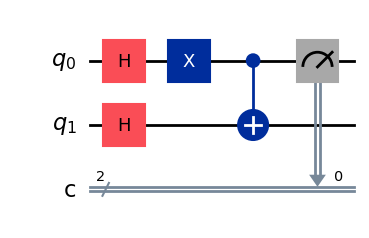

In [3]:
from qiskit import QuantumCircuit

circ_example = QuantumCircuit(2, 2)
circ_example.h(range(2))
circ_example.x(0)
circ_example.cx(0, 1)
circ_example.measure(0,0);
circ_example.draw(output="mpl")


The $q_0$ and $q_1$ label the two qubits, and the $c$ labels the classical register, that is, the classical bits which receive the measurements.

The boxes with $H$ and $X$ labels are the one-qubit gates (Pauli $X$ and Hadamard, respectively), and the vertical line linking a $q_0$ to $q_1$ with a plus sign is a two-qubit gate, called $CX$ or $CNOT$. At the end, the gauge icon labels a measurement on the qubit $q_0$: note that this is a non-unitary operation, it collapses the wavefunction to one of the classical outcomes. Here, we only measure $q_0$ and do not care about qubit $q_1$, but we could also measure it if we wanted.

# Creating a quantumc circuit

Now, let's walk through all the steps that we need to create a circuit. First, we define the QuantumCircuit object by specifying the number of qubits and the number of classical bits (to receive the measurements)

In [4]:
n_qubits = 2
n_classical_bits = 2

circuit = QuantumCircuit(n_qubits,n_classical_bits)

Now we apply gates on this circuit by calling the respective function on the desired qubit. For example, a NOT gate, which we call in quantum computing an $X$ gate, can be added to the first qubit (index 0) like so:

In [5]:
circuit.x(0)

# Sampling quantum circuits

Let's see what the output of this circuit is; we need, however, to make a few remarks before proceeding.

Quantum circuits are very much like classical circuits in a sense: the qubits store information, and we act on them using gates. Unlike classical circuits, quantum circuits have probabilistic outcomes: if I measure the qubits, I get a string of bits (like $|0111011011\rangle$, for example), often called a bitstring (guess why), which is only one out of many possible realizations. Therefore, one needs to _sample_ a circuit many times, in order to reconstruct either the wavefunction (you usually try to avoid that, because it is not efficient) or to get an expectation value $\langle \psi | \hat{O} | \psi \rangle$, where $|\psi\rangle$ is the wavefunction at the end of the circuit. Hence, we need to create a function that simulates the quantum evolution of the circuit, and then get samples from that distribution.

If I measure the simple circuit defined above, I should only ever get the $|01\rangle$ state, since we start in the $|00\rangle$ state, and we apply a bitflip to the first qubit (qiskit has a right-to-left ordering).

We use the "Statevector" quantum simulator, which simulates the whole quantum state as a vector (hence the name); it is the standard one, although not very efficient. Note that for a technical reason that is not of much importance for now, we are not using the classical bits, but rather directly getting our information from the state vector.

We put together the necessary steps to sample the circuit easily:

In [6]:
from qiskit.quantum_info import Statevector

# we input a circuit and a number of samples, and obtain a dictionary of outcomes
def sample_circuit(circuit: QuantumCircuit,n_samples:int) -> dict:
  statevector = Statevector.from_instruction(circuit)
  outcomes = statevector.sample_counts(n_samples)
  return outcomes


# function that print all the outcomes
def print_outcomes(outcomes:dict):
  for bitstring,counts in outcomes.items():
    print(f"Obtained bitstring |{bitstring}> {counts} times.")


Back to our circuit.

Let's call the `sample_circuit` function we defined before.

In [7]:
# we sample the circuit a 100 times, and see what the outcomes are

n_samples = 100
outcomes = sample_circuit(circuit,n_samples)
print_outcomes(outcomes)


Obtained bitstring |01> 100 times.


As expected, we only get the $|01\rangle$ bitstring.

Let's move on to more complex circuits. This is quantum computing, so let's add some superposition to the mix. The Hadamard gate $H$ sends a qubit to a superposition, $|0\rangle \to |0\rangle + |1\rangle$ (what do you think happens if we apply it to $|1\rangle$?)

We add the gate to the second qubit and meausre our circuit again:


In [8]:

# add to second qubit, index 1
circuit.h(1)

# sample circuit again
n_samples = 100
outcomes = sample_circuit(circuit,n_samples)
print_outcomes(outcomes)


Obtained bitstring |01> 48 times.
Obtained bitstring |11> 52 times.


Now, the outcomes are one of two different bitstrings, since the wavefunction we measure is in a superposition, and a measurement collapses it to one of the bitstrings which make up the superposition.

Of course, we also need to take two-qubit gates into account, because superposition is not what makes quantum computing hard to do classically (what is it then?).

This can be easily done the same way as before. Let us add a controlled not gate $CX$ to our circuit. It has a control qubit, which decides whether to apply a X gate on the target qubit: if the control qubit is $|1\rangle$ we apply the X gate, if it is $|0\rangle$, we do nothing.

Let's add that gate, and sample the circuit again.

In [9]:

# add a CX gate
control_qubit = 1
target_qubit = 0
circuit.cx(control_qubit,target_qubit)

# sample circuit again
n_samples = 100
outcomes = sample_circuit(circuit,n_samples)
print_outcomes(outcomes)

Obtained bitstring |01> 48 times.
Obtained bitstring |10> 52 times.


Do you understand why the bitstrings are what they are? How do Hadamard and two-qubit gates interact?

I'll leave you for now with these questions. Those were the very fundamentals of qiskit, and you now know how to build a circuit and get measurements out of it.

# Simple exercise

Before parting, let's try a simple exercise.

Write a circuit that gives (roughly) half of the time $|000\rangle$ and the other half $|111\rangle$, so that you get a print output like:

```
Obtained bitstring |000> 49 times.
Obtained bitstring |111> 51 times.
 ```

In [10]:

your_circuit = QuantumCircuit(3,3)

# YOUR CODE HERE

# sample circuit
n_samples = 100
outcomes = sample_circuit(your_circuit,n_samples)
print_outcomes(outcomes)

Obtained bitstring |000> 100 times.
